# droidlet for Physical Robots

In this tutorial, we implement an agent that takes commands from humans in natural language, and executes those commands on a physical robot.

At the end of this tutorial, you should be able to give a command ***go to the chair***, and the robot will physically go to the closest chair that it finds.


The robot that we are going to use is a [locobot](http://www.locobot.org/). It costs [$5,000](https://www.robotshop.com/en/locobot-pyrobot.html), it has an RGB + Depth camera, a wheel base and an arm. It looks like this:

<div>
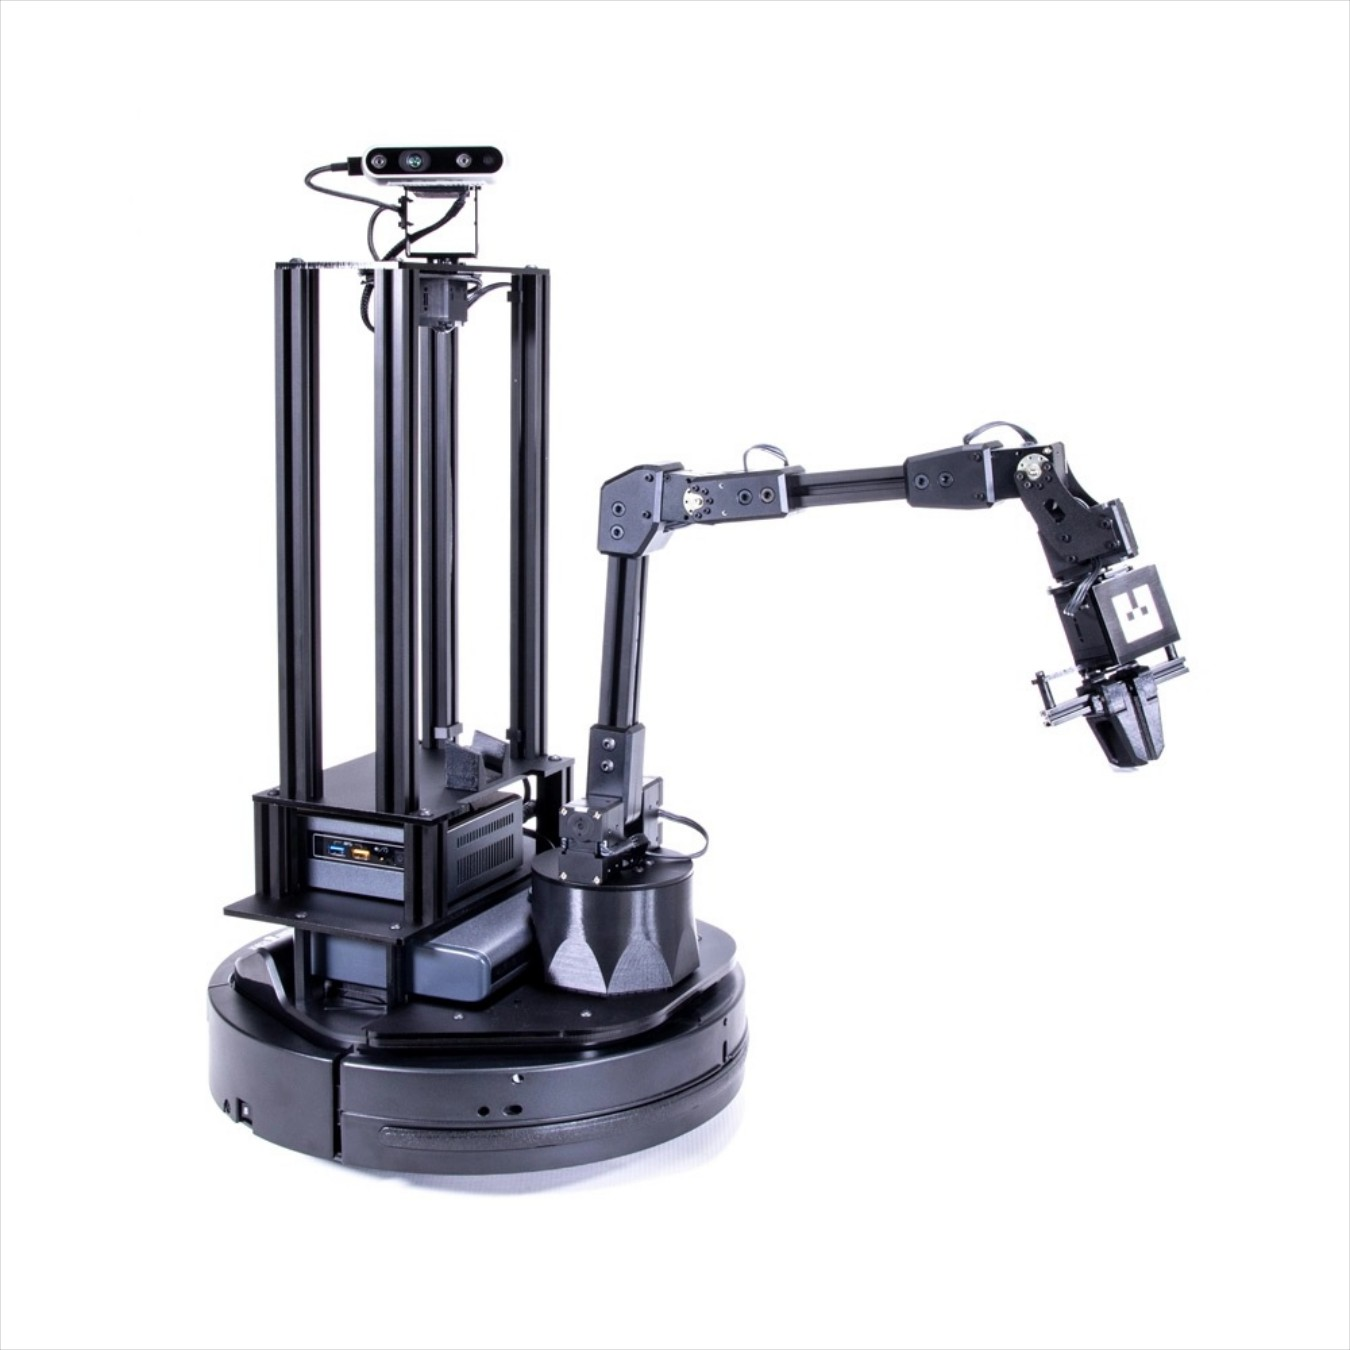
</div>

Because we don't have a locobot and don't want to spend that kind of money to do the droidlet tutorial, we use a photorealistic simulator that simulates locobot. This simulator is called [Habitat](https://aihabitat.org/). This simulator can simulate everything about the locobot except it's arm. So as an approximation, we are going to pretend that there is no arm.

## Prerequisites


1. Make sure that you have [**droidlet installed**](https://github.com/facebookresearch/fairo#getting-started)
2. For this tutorial, we require a Linux machine with a CUDA-enabled GPU
3. We are going to use a photorealistic robot simulator called Habitat for this tutorial. For easy installation and launching of the simulator, [install Docker](https://docs.docker.com/get-docker/) on your computer.
4. From the root directory of the droidlet repository, run the command `tools/data_scripts/try_download.sh locobot`. This downloads the relevant model artifacts for the various neural network models used by `droidlet`

Lastly, make sure that you cover the basic tutorial [How to build a Simple Agent](https://github.com/facebookresearch/fairo/blob/main/tutorials/how_to_build_a_simple_agent.ipynb).

It introduces you to the basic set of abstractions and concepts in `droidlet`: Memory, Perception, Controller and Tasks.

## Start the Habitat simulator in the background

The one last step we need to do before we start our tutorial is to start the Habitat simulator and have it available for our agent to talk to.

Open a separate Terminal, and Follow steps 1 and 2 at this [link](https://github.com/facebookresearch/fairo/tree/main/locobot#getting-started) to start a Habitat server.
If everything goes well, you should see a message `Server is started...` on the Terminal.

Once you see that message, come back here.

## Implementing the agent: 4 components

As a reminder from the basic tutorial, these are the steps involved in creating an agent:

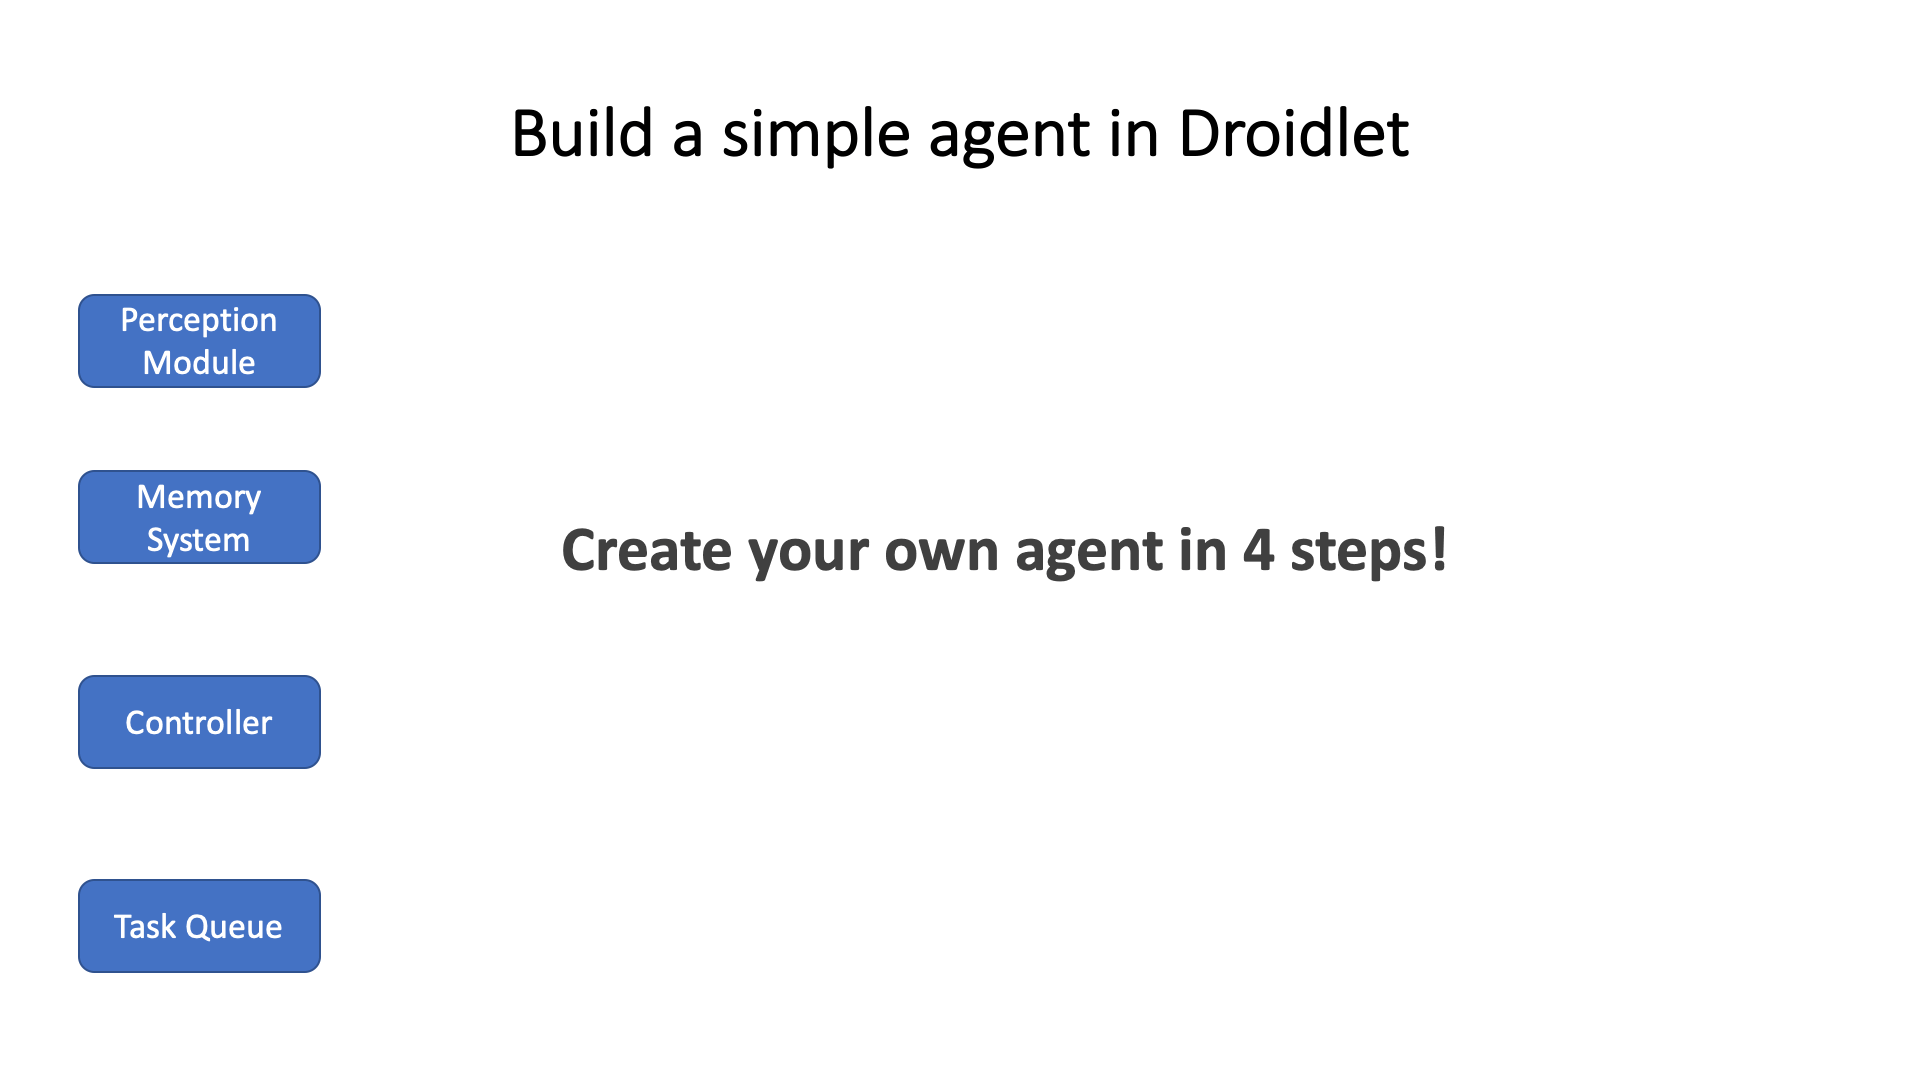

Then, the agent roughly runs the following event loop:

> **while** True **do**
>> run [perceptual modules](https://facebookresearch.github.io/fairo/perception.html), update [memory](https://facebookresearch.github.io/fairo/memory.html)
>>
>> step [controller](https://facebookresearch.github.io/fairo/controller.html)
>>
>> step highest priority [task](https://facebookresearch.github.io/fairo/tasks.html)

We divide this tutorial into 6 steps.

- Step 1: Display it's RGB and Depth sensors, move the robot manually
- Step 2: Put an object detection perception pipeline for the robot that detects objects and stores their properties and location into the agent's memory
- Step 3: Use a pre-built dialog parser that parses natural language text into a canonical intermediate representation (IR)
- Step 4: Create a small controller that converts the IR from step 3 into tasks for the robot
- Step 5: Tie all these together, display the robot sensors into a dashboard interface and test some commands

## Step 1: Display the sensors, move the robot

To display sensors, we shall use a small dashboard interface that we built as part of droidlet.
It has a few sensor display panes, some text boxes and some debugging panes that can see the internal state of the robot, including it's memory.

In [1]:
import dldashboard
dldashboard.start()
from dlevent import sio as dash

**Open dashboard in a separate browser window at [http://localhost:8000](http://localhost:8000) and have it available side by side with the Jupyter Notebook as you execute the notebook code.**

When we change the state of the robot, we will observe it in this dashboard.
We can send data to this dashboard using `dash.emit` calls, as you will see below. The dashboard is bi-directional. We can get inputs from the dashboard via `@dash.on` functions that we register on specific events. Getting inputs from the dashboard is out of scope of this tutorial.

Let us first begin by creating a `LocoBotMover` object that gets a raw handle to the robot interface.

In [2]:
from locobot.agent.locobot_mover import LoCoBotMover

In [3]:
locobot = LoCoBotMover(ip="172.17.0.2", backend="habitat")

This `mover` object now gives you a raw low-level interface to the robot.
It is located [here](https://github.com/facebookresearch/fairo/blob/main/locobot/agent/locobot_mover.py#L28) with inline docstrings.

It has functions such as `move_relative`, `move_absolute`, `turn` to move the robot, `get_base_pos` to get the robot position in world co-ordinates, `get_rgb_depth` to get the RGB-D images and a few more functions related to controlling the arm (which we shall ignore) such as `point_at`, `grab_nearby_object`, `drop` and more.

**Display camera images**

We can display the current RGB images to the dashboard with the following snippet:

In [4]:
rgbdepth = locobot.get_rgb_depth()
rgb, depth = rgbdepth.to_struct().values() # convert to a simple json-ish object

dash.emit("rgb", rgb)
dash.emit("depth", depth)
# dash.emit("sensor_payload", {"image": rgbdepth.to_struct()})

Let us make this a function for future reference

In [5]:
def display_rgbd():
    rgb, depth = locobot.get_rgb_depth().to_struct().values()
    dash.emit("rgb", rgb)
    dash.emit("depth", depth)

Now, see the dashboard above. There should be two movable and resizeable panes that display the RGB and Depth images from the robot's camera.
We are in a house with two humans, and some furniture such as chairs and sofas.

**Unsupervised Exploration**

One of the primitives that comes with locobot is to set it to an unsupervised `explore()` mode, where it goes around the environment and tries to absorb information.

Let us put the locobot in explore mode and observe the camera for 15 seconds.
Run the code below and look at the dashboard above.

In [6]:
import time
start_time = time.time()

while time.time() - start_time < 15: # run for 15 seconds
    
    # explore the environment
    locobot.explore() 
    
    # get new camera images and display them in the dashboard
    display_rgbd()
    
    time.sleep(0.3)

**Moving controls**

Let us move the robot relative to itself with manual controls.

In [7]:
rel_position = (0.1, 0.0, -0.5) # x, y, yaw
locobot.move_relative(rel_position)
display_rgbd()

## Step 2: Perception and memory for the robot

Now that we have the basic sensors, visualization and movement of the robot handled, we move on to the next step.

First, let us build the perception pipeline for the robot. We have RGB and Depth images coming out of the robot. These can be processed by computer vision models to extract semantic information about the scene.

`droidlet` [provides a few built-in modules](https://github.com/facebookresearch/fairo/tree/main/locobot/agent/perception/handlers) to extract such semantic information. A few examples are:

- An object detector that outputs object names and their properties (such as color)
- An object tracker that tracks objects across space and time as the robot moves. This helps the robot in deduplicating object instances that it detects across frames
- A face recognizer wrapped from the open-source [dlib](http://dlib.net/) library
- A human detector along with the estimation of the detected human's pose

In this tutorial, let us use the object detector and tracker.

In [8]:
from locobot.agent.perception.handlers import DetectionHandler, ObjectDeduplicationHandler

The `perception` classes named `*Handler` have a very simple interface.
They have:
- a constructor `__init__` which initializes the object, loading any needed models and metadata.
- a `handle(...)` function that takes the expected input and returns the semantically processed output

The `input` expected and `output` returned by the `handle` function are documented in the docstring of the particular class.

**Object Detection**

For a little bit of fun, let us process our rgb-depth images through the `DetectionHandler` and visualize the outputs in the dashboard.

Initializing the `DetectionHandler` involves pointing it to the directory where the model weights are located.

In [9]:
import os

# path where the model weights were downloaded
model_weights_dir = os.path.abspath(os.path.join(os.getcwd(), "../", "locobot", "agent", "models", "perception"))

detector = DetectionHandler(model_weights_dir)

The `detector`'s handle here takes the `RGBDepth` object returned by the robot's `get_rgb_depth()` call, and returns the detected object locations in 3D global co-ordinates as well as their semantic properties.

For 30 frames, let us put the robot in `explore` mode, run the detector and visualize the objects in the dashboard

In [10]:
for i in range(30):
    locobot.explore()

    # get the image and process it to get the detected objects
    rgb_depth = locobot.get_rgb_depth()
    objects = detector(rgb_depth)

    # send to the dashboard for display
    dash.emit("objects", {"image": rgb_depth.to_struct(),
                   "objects": [o.to_struct() for o in objects]})

**Object Deduplication**

The object deduplicator has a simple self-explanatory API. It takes objects and compares them to previously stored / objects. If they are previous instances, it discards the metadata from the current objects, and merges them with the previous objects.

Let us run the object detector and deduplicator for a few frames, printing out the total number of objects detected, and the total unique number of objects after the de-duplication.

The deduplicator is able to de-duplicate the objects across multiple frames efficiently.

In [11]:
deduplicate = ObjectDeduplicationHandler()

# TODO: if exploration ends, the robot is sitting at the same place in the scene without moving

all_objects = [] # let us store all deduplicated objects in this list
total_detections = 0
for i in range(30):
    locobot.explore()

    rgb_depth = locobot.get_rgb_depth()
    current_objects = detector(rgb_depth)    
    total_detections += len(current_objects)
    
    # deduplicates new objects from all objects
    new_objects, updated_objects = deduplicate(current_objects, all_objects)
    all_objects += new_objects
    
    print("Frame {}: Total Detections: {}, De-duplicated and Unique Objects: {}".format(
        i, total_detections, len(all_objects)))

**Memory**

Now we have setup a small object detection + deduplication pipeline.

But the robot is not storing the information of these objects in it's memory yet.

If it doesn't store this information in memory, then when you say "go to the chair", it does not know where the chair is (unless the chair is in it's field of view at that given moment).

`droidlet` provides a memory system that can store generic metadata. This memory system is used by the Dialog Parser + Task controller to do tasks utilizing context provided by information stored in memory.

The memory is backed by an SQL database, and has schemas to represent common semantic information for robots and the environment.

Let us first create the default `AgentMemory` object for our Locobot using some pre-baked and thoughtful memory schemas.

In [12]:
from base_agent.sql_memory import AgentMemory
from locobot.agent.loco_memory_nodes import NODELIST

SQL_SCHEMAS = [
    os.path.join(os.getcwd(), "../", "base_agent", "base_memory_schema.sql"),
    os.path.join(os.getcwd(), "../", "locobot", "agent", "loco_memory_schema.sql"),
]

In [13]:
memory = AgentMemory(db_file=":memory:", schema_paths=SQL_SCHEMAS, nodelist=NODELIST)

We can see the types of nodes that can be stored inside the memory

In [14]:
memory.nodes

Let us store the previously detected objects into memory, using this new memory system.

For this, we will use the `DetectedObjectNode`.
A physical `object` is represented in memory as a `DetectedObjectNode`, which is thoughtfully annotated with properties such as it's `color` and it's detected `xyz` location.

As a reminder, in the previous section, we deduplicated the objects detected in the scene, and stored them in the variable `previous_objects`.

Now, we will store these `all_objects` into the memory.
Let us start with storing and retreiving one object, and inspecting the results.

In [15]:
from locobot.agent.loco_memory_nodes import DetectedObjectNode

memory_id = DetectedObjectNode.create(memory, all_objects[0])

Now, let us retreive the `DetectedObjectNode` from memory.

In [16]:
memory.get_mem_by_id(memory_id)

The memory object is in it's raw packed form, and is not yet converted back to a dict with accessible fields.

We can access the detected objects back from memory as dicts using the `get_all` function:

In [17]:
DetectedObjectNode.get_all(memory)

Now, let us store the rest of the detected objects into memory

In [18]:
for obj in all_objects[1:]: # we already stored all_objects[0]
    DetectedObjectNode.create(memory, obj)

## Section 3: Neural Dialog Parser

Now that we have the objects stored in memory, let us start from the other side of the pipeline.

Let us use a pre-built dialog parser that parses natural language text into a canonical intermediate representation (IR).

In [19]:
from base_agent.nsp_dialogue_manager import DialogModel

dialog_model_dir = os.path.abspath(os.path.join(os.getcwd(), "../", "locobot", "agent", "models", "semantic_parser/"))
dialog_data_dir = os.path.abspath(os.path.join(os.getcwd(), "../", "locobot", "agent", "datasets", "annotated_data/"))

dialog = DialogModel(dialog_model_dir, dialog_data_dir)

Now that we created this dialog model, let us look at the IR for our sentence of interest **"go to the chair"**

In [20]:
dialog.get_logical_form("go to the chair")

The parsed IR has a few fields of interest.

The `dialog_type` clearly says that is a command that was given by a human. Other types of dialogs in the IR are `PUT_MEMORY`, `GET_MEMORY`, `NOOP`, which are internal dialogues to the agent.

When we build a full agent, where the agent has a full controller and interpreter stack, the agent can decide to do those actions itself. When the agent decides to store an perceived object in memory, for example, then it issues itself a `PUT_MEMORY` dialog that is pushed onto it's dialog stack, which is then subsequently executed by the interpreter.

The `action_sequence` here is to issue a `MOVE` command to the agent, to the `location` of the object with the text `chair`. We have a `filters` system that is effectively able to query the memory for particular instances of things stored in memory.

**One of the more interesting things about our Dialog model is that regardless of the variants of the text given to the model, it canonicalizes to the same IR.**

Let us try a few similar but differently worded sentences.

In [21]:
dialog.get_logical_form("can you please move to the chair")

In [22]:
dialog.get_logical_form("stand next to the chair")

In [23]:
dialog.get_logical_form("immediately advance to the chair and then go to the table")

## Step 4: Create a small controller that converts the IR from step 3 into actions for the robot

Now, let us create a small "dumb" interpreter that:
- consumes the canonical IR for "go to the chair"
- gets the current location of a chair from memory
- issues commands to the robot to move itself to the location of the chair

We can build this using all the concepts we learnt in Step 2, along with issuing the command `move_absolute` to the `LoCoBotMover`

In [24]:
def controller(logical_form):

    # let us only handle HUMAN_GIVE_COMMAND nodes in the IR
    assert logical_form['dialogue_type'] == 'HUMAN_GIVE_COMMAND'
    
    actions = logical_form['action_sequence']
    
    for action in actions:
        if action['action_type'] == 'MOVE':
            
            # we only handle moving towards a detected object
            assert 'reference_object' in action['location']
            
            # using the filter, search for the object in memory:
            objects = memory.basic_search(action['location']['reference_object']['filters'])
            
            # if an object with the given label is found, then move the robot towards the object
            if len(objects) > 0:
                # select the first matched object                
                obj = objects[0]
                
                object_label = memory.get_triples(obj.get_properties()['memid'])[1][2]
                print("Moving to the " + object_label)
                locobot.move_absolute(obj.pos)
            else:
                print("Could not find the object in the current environment")
            

In a few lines, we have built a one-command interpreter in a few lines.
It interprets sentences that are paraphrased as "move to object-X" and are invariant to the `object` being referenced and to many sentences that convey the same message.

Let us now test our interpreter:

In [26]:
logical_form = dialog.get_logical_form("go to the desk")
controller(logical_form)
display_rgbd()

The controller works as expected.

Now, try a few different input sentences and see what happens.

## Summary and next steps

So far, you have learned about the following concepts:

- Getting input and output to the locobot via `LocobotMover`
- Using perception handlers to extrac semantic information such as object detections out of the environment
- storing the objects in the agent memory for context
- using a pre-trained dialog model that canonicalizes what the user says into an intermediate representation (IR)
- writing a small controller that interprets this IR in the scope of a small set of commands

This ends the scope of this tutorial.

If you build an agent that needs to handle a variety of commands and does many tasks, then the naive controller that we wrote in Step 4 becomes quickly insufficient.

Hence, in droidlet, we introduce formal concepts of `Interpreter`, `Task` and `DialogueStack` that make it easy to write powerful and complex Agents.

Here are some next steps to do:

- Go through the documentation for [`Controller`](https://facebookresearch.github.io/fairo/controller.html) and [`Tasks`](https://facebookresearch.github.io/fairo/tasks.html).
- Read the source code of, and try to run + play with the full-featured [locobot agent](https://github.com/facebookresearch/fairo/blob/eec4bdad06350251d862ea326470cbefb1f0a8df/locobot/agent/locobot_agent.py)
- Read more about the Dialogue parser, in the tutorials make_new_dataset.ipynb and semantic_parser_onboarding.ipynb
